# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки:

DateCrawled — дата скачивания анкеты из базы  
VehicleType — тип автомобильного кузова  
RegistrationYear — год регистрации автомобиля  
Gearbox — тип коробки передач
Power — мощность (л. с.)  
Model — модель автомобиля  
Kilometer — пробег (км)  
RegistrationMonth — месяц регистрации автомобиля  
FuelType — тип топлива  
Brand — марка автомобиля  
Repaired — была машина в ремонте или нет  
DateCreated — дата создания анкеты  
NumberOfPictures — количество фотографий автомобиля  
PostalCode — почтовый индекс владельца анкеты (пользователя)  
LastSeen — дата последней активности пользователя  

Целевой признак: 

Price — цена (евро)

## Подготовка данных

### Загрузка данных

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
RANDOM_STATE=42

In [42]:
data = pd.read_csv('/datasets/autos.csv')

In [43]:
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Предобработка данных

In [45]:
data.duplicated().sum()

4

In [46]:
data = data.drop_duplicates()

In [47]:
data.columns = data.columns.str.lower()

In [48]:
#удаляем признаки, которые по смыслу задачи не несут важной информации
data = data.drop(['datecrawled', 'registrationmonth', 'datecreated', 'numberofpictures','postalcode','lastseen'], axis=1)

In [49]:
data.isna().sum()

price                   0
vehicletype         37490
registrationyear        0
gearbox             19833
power                   0
model               19705
kilometer               0
fueltype            32895
brand                   0
repaired            71154
dtype: int64

In [50]:
data.describe()

,price,registrationyear,power,kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


In [51]:
quant_columns = data.select_dtypes(include='number').columns.tolist()

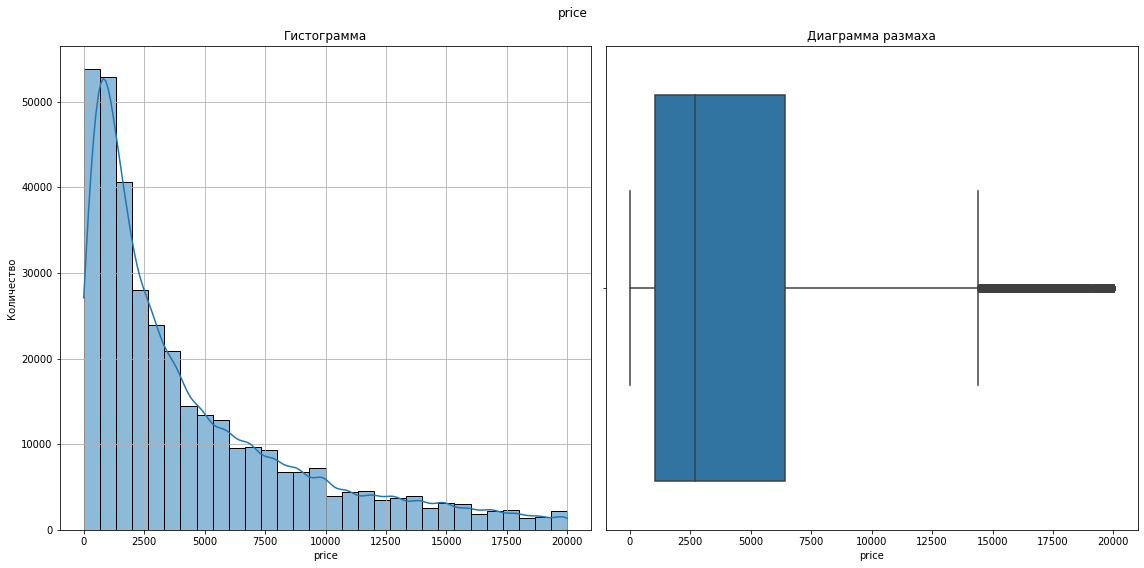

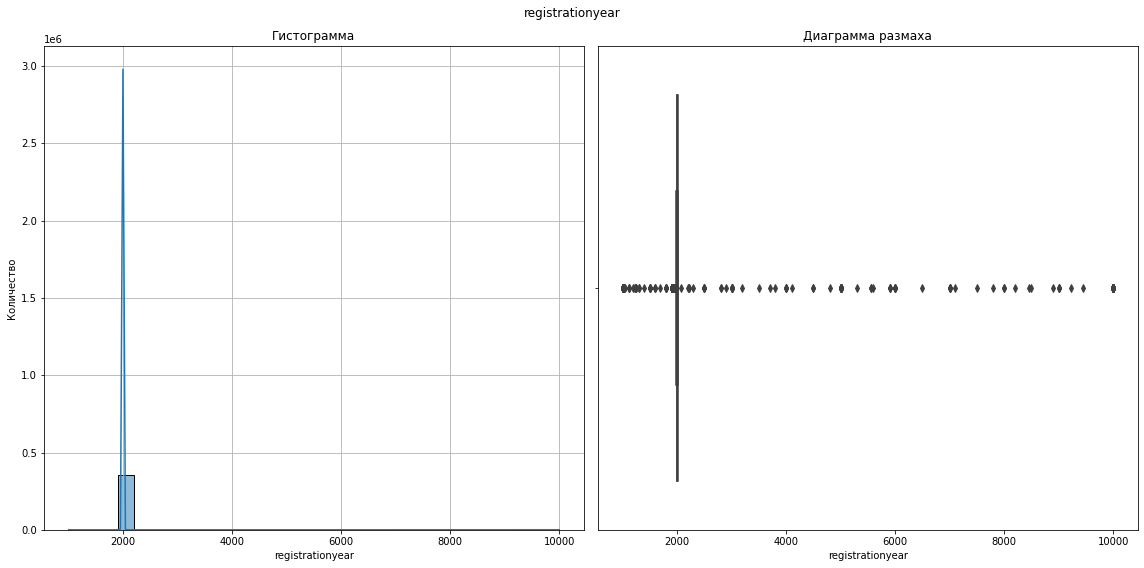

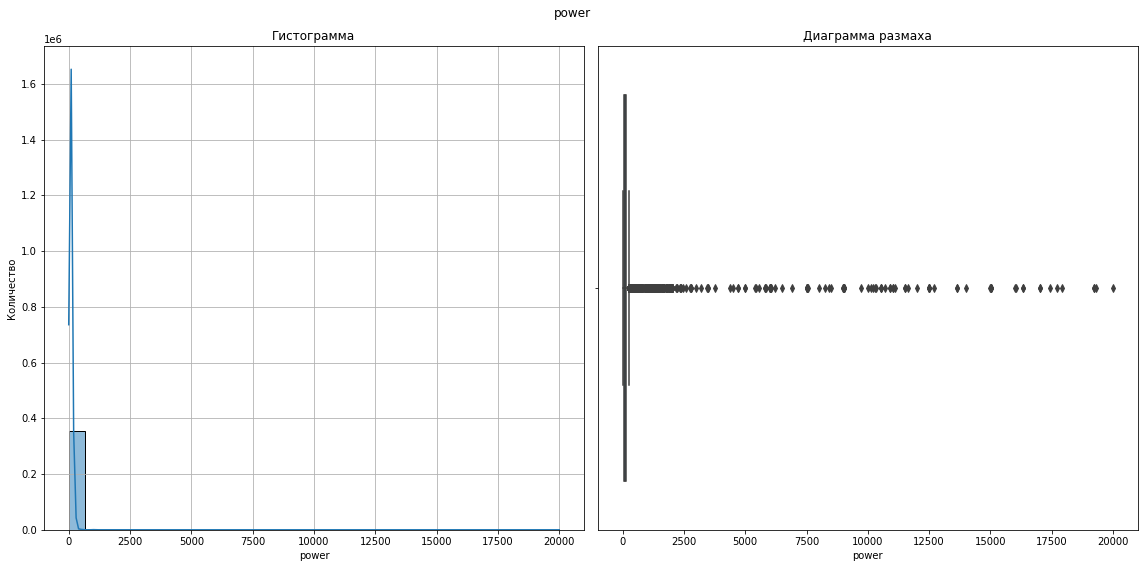

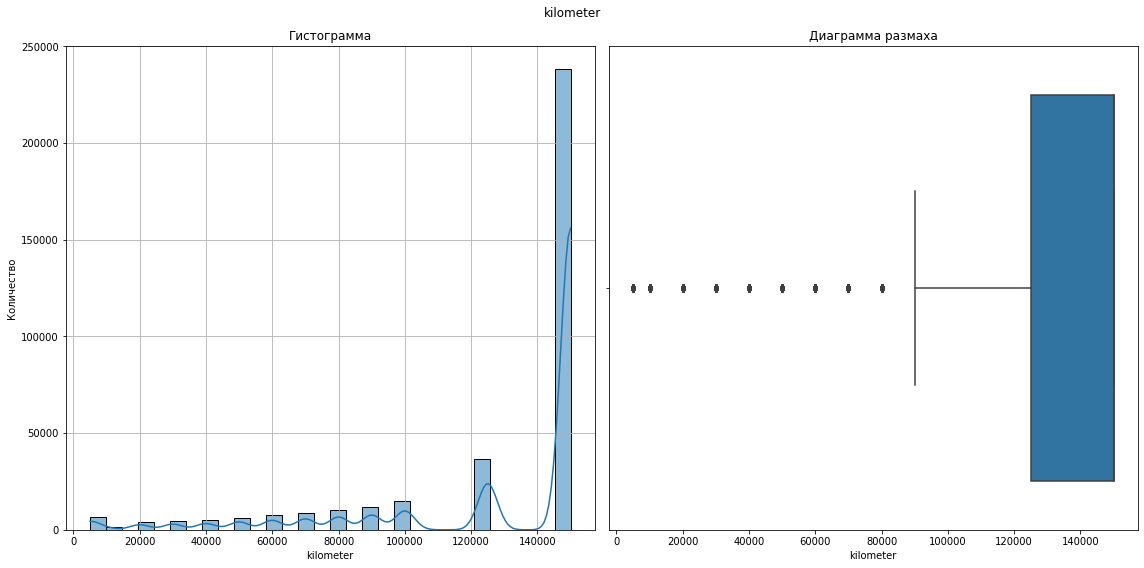

In [52]:
for i in quant_columns:
    fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
    sns.histplot(data = data,x = i, ax=axs[0], bins = 30, kde=True)
    axs[0].set_xlabel(i)
    axs[0].set_ylabel('Количество')
    axs[0].set_title('Гистограмма')
    axs[0].grid(True)
    sns.boxplot(data = data,x = i, ax=axs[1])
    axs[1].set_xlabel(i)
    axs[1].set_title('Диаграмма размаха')
    fig.suptitle(i)
    plt.tight_layout()
    plt.show()

In [53]:
len(data.query('price<300'))

23163

In [54]:
# убираем нулевые и околонулевые цены, чтобы не портить качество моделей
data = data.query('price>300')

In [55]:
len(data.query('power>1000 or power<50'))

36167

In [56]:
# убираем околонулевые мощности и мощности свыше 1000 сил, так как они кажутся неправдоподобыми
data = data.query('power<1000 and power>50')

In [57]:
len(data.query('registrationyear>2025 or registrationyear<1960'))

86

In [58]:
# убираем неправдоподобные даты(начинались с 1000г и доходили до 9999г)
data = data.query('registrationyear<2025 and registrationyear>1960')

In [59]:
len(data.query('model.isna()==1'))

10841

In [60]:
# убираем пропущенные значения моделей, так как восстановить данные невозможно, а они сильно влияют на цену
data = data.query('model.isna()==0')

In [61]:
#пропуски заполняем заглушкой
data['repaired'] = data['repaired'].fillna('unknown')

In [62]:
data['vehicletype'] = data['vehicletype'].fillna(
    data.groupby('model')['vehicletype']
        .transform(lambda x: x.value_counts().idxmax())
)

In [63]:
data['gearbox'] = data['gearbox'].fillna(
    data.groupby('model')['gearbox']
        .transform(lambda x: x.value_counts().idxmax())
)

In [64]:
data['fueltype'] = data['fueltype'].fillna(
    data.groupby('model')['fueltype']
        .transform(lambda x: x.value_counts().idxmax())
)

vehicletype, gearbox, fueltype заполняем наиболее частыми значениями встречающимися у моделей.

In [65]:
data.isna().sum()

price               0
vehicletype         0
registrationyear    0
gearbox             0
power               0
model               0
kilometer           0
fueltype            0
brand               0
repaired            0
dtype: int64

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277329 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             277329 non-null  int64 
 1   vehicletype       277329 non-null  object
 2   registrationyear  277329 non-null  int64 
 3   gearbox           277329 non-null  object
 4   power             277329 non-null  int64 
 5   model             277329 non-null  object
 6   kilometer         277329 non-null  int64 
 7   fueltype          277329 non-null  object
 8   brand             277329 non-null  object
 9   repaired          277329 non-null  object
dtypes: int64(4), object(6)
memory usage: 23.3+ MB


Загрузили библиотеки, объявили константы. Проведена предобработка данных. Удалены дубликаты и аномальные значения.

## Обучение моделей

### LinearRegression

In [67]:
X = data.drop(['price'], axis=1)
y = data['price']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [69]:
cat_col_names = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'repaired']
num_col_names = ['power', 'kilometer', 'registrationyear']

In [70]:
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names(cat_col_names)
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

In [71]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

In [72]:
X_train_preprocessed = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_preprocessed = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [73]:
lr_model = LinearRegression()

In [74]:
#находим RMSE
mse = cross_val_score(lr_model, X_train_preprocessed, y_train, cv=5, scoring='neg_mean_squared_error')
print('RMSE для LinearRegression =',(-mse).mean()**0.5)

RMSE для LinearRegression = 2621.5736101192747


In [75]:
%%time
lr_model.fit(X_train_preprocessed, y_train) # Время обучения

CPU times: user 14.8 s, sys: 3.77 s, total: 18.6 s
Wall time: 18.6 s


LinearRegression()

In [76]:
%%time
y_pred_lr = lr_model.predict(X_train_preprocessed) # Вреся предсказания

CPU times: user 181 ms, sys: 14 ms, total: 195 ms
Wall time: 194 ms


### DecisionTreeRegressor

In [77]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_ord = encoder.fit_transform(X_train[cat_col_names])
X_test_ord = encoder.transform(X_test[cat_col_names])
X_train_ord = pd.DataFrame(X_train_ord, columns=cat_col_names)
X_test_ord = pd.DataFrame(X_test_ord, columns=cat_col_names)

In [78]:
X_train_preprocessed = pd.concat([X_train_ord, X_train_scaled], axis=1)
X_test_preprocessed = pd.concat([X_test_ord, X_test_scaled], axis=1)

In [81]:
dt_model = DecisionTreeRegressor(random_state=42)

In [82]:

%%time
dt_model.fit(X_train_preprocessed, y_train) # Время обучения

CPU times: user 824 ms, sys: 0 ns, total: 824 ms
Wall time: 826 ms


DecisionTreeRegressor(random_state=42)

In [83]:
dt_model = DecisionTreeRegressor(random_state=42)

In [84]:
param_dt = {
    'max_depth': range(2,15),
    'min_samples_split': range(2,20),
    'min_samples_leaf': range(2,10),
}


In [85]:
random_search_dt = RandomizedSearchCV(
    dt_model,
    param_dt, 
    n_iter=10, 
    cv=3, 
    scoring='neg_mean_squared_error',
    verbose=10,
    n_jobs=-1)

In [86]:
random_search_dt.fit(X_train_preprocessed, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START max_depth=8, min_samples_leaf=4, min_samples_split=6.......
[CV 1/3; 1/10] END max_depth=8, min_samples_leaf=4, min_samples_split=6; total time=   0.3s
[CV 2/3; 1/10] START max_depth=8, min_samples_leaf=4, min_samples_split=6.......
[CV 2/3; 1/10] END max_depth=8, min_samples_leaf=4, min_samples_split=6; total time=   0.2s
[CV 3/3; 1/10] START max_depth=8, min_samples_leaf=4, min_samples_split=6.......
[CV 3/3; 1/10] END max_depth=8, min_samples_leaf=4, min_samples_split=6; total time=   0.3s
[CV 1/3; 2/10] START max_depth=11, min_samples_leaf=5, min_samples_split=2......
[CV 1/3; 2/10] END max_depth=11, min_samples_leaf=5, min_samples_split=2; total time=   0.3s
[CV 2/3; 2/10] START max_depth=11, min_samples_leaf=5, min_samples_split=2......
[CV 2/3; 2/10] END max_depth=11, min_samples_leaf=5, min_samples_split=2; total time=   0.3s
[CV 3/3; 2/10] START max_depth=11, min_samples_leaf=5, min_samples_split

RandomizedSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': range(2, 15),
                                        'min_samples_leaf': range(2, 10),
                                        'min_samples_split': range(2, 20)},
                   scoring='neg_mean_squared_error', verbose=10)

In [87]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame(random_search_dt.cv_results_)[
    ['params', 'std_test_score', 'mean_test_score','mean_fit_time']
].sort_values('mean_test_score', ascending=False).head(3)

,params,std_test_score,mean_test_score,mean_fit_time
1,"{'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 11}",51083.911614,-3.764999e+06,0.316352
4,"{'min_samples_split': 12, 'min_samples_leaf': 7, 'max_depth': 10}",41403.945402,-3.957656e+06,0.293932
6,"{'min_samples_split': 17, 'min_samples_leaf': 5, 'max_depth': 10}",37249.586258,-3.960380e+06,0.293972


In [88]:
# RMSE модели
mse = -(random_search_dt.best_score_)
print('RMSE для DecisionTreeRegressor =', mse**0.5)

RMSE для DecisionTreeRegressor = 1940.3606145501265


In [89]:

%%time
y_pred_dt = random_search_dt.best_estimator_.predict(X_train_preprocessed) # Время предсказания

CPU times: user 29.1 ms, sys: 0 ns, total: 29.1 ms
Wall time: 28.4 ms


### LightGBM

In [90]:
param_lgbm  = {
    'learning_rate': [0.5],
    'max_depth': [3, 5, 7]}

In [91]:
lgbm = LGBMRegressor(n_estimators=50, random_state=42)

In [92]:
%%time
lgbm.fit(X_train_preprocessed, y_train) # Время обучения

CPU times: user 3.26 s, sys: 0 ns, total: 3.26 s
Wall time: 3.26 s


LGBMRegressor(n_estimators=50, random_state=42)

In [93]:
lgbm = LGBMRegressor(n_estimators=50, random_state=42)

In [94]:
random_search_lgbm = RandomizedSearchCV(
    lgbm,
    param_lgbm,
    scoring='neg_mean_squared_error',
    cv=2,
    n_iter=3,
    verbose=10,
    n_jobs=-1
)

In [95]:
random_search_lgbm.fit(X_train_preprocessed, y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV 1/2; 1/3] START learning_rate=0.5, max_depth=3..............................
[CV 1/2; 1/3] END ............learning_rate=0.5, max_depth=3; total time=   1.2s
[CV 2/2; 1/3] START learning_rate=0.5, max_depth=3..............................
[CV 2/2; 1/3] END ............learning_rate=0.5, max_depth=3; total time=   1.3s
[CV 1/2; 2/3] START learning_rate=0.5, max_depth=5..............................
[CV 1/2; 2/3] END ............learning_rate=0.5, max_depth=5; total time=   1.7s
[CV 2/2; 2/3] START learning_rate=0.5, max_depth=5..............................
[CV 2/2; 2/3] END ............learning_rate=0.5, max_depth=5; total time=   1.7s
[CV 1/2; 3/3] START learning_rate=0.5, max_depth=7..............................
[CV 1/2; 3/3] END ............learning_rate=0.5, max_depth=7; total time=   2.1s
[CV 2/2; 3/3] START learning_rate=0.5, max_depth=7..............................
[CV 2/2; 3/3] END ............learning_rate=0.5, m

RandomizedSearchCV(cv=2,
                   estimator=LGBMRegressor(n_estimators=50, random_state=42),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'learning_rate': [0.5],
                                        'max_depth': [3, 5, 7]},
                   scoring='neg_mean_squared_error', verbose=10)

In [96]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame(random_search_lgbm.cv_results_)[
    ['params', 'std_test_score', 'mean_test_score','mean_fit_time']
].sort_values('mean_test_score', ascending=False).head(3)

,params,std_test_score,mean_test_score,mean_fit_time
2,"{'max_depth': 7, 'learning_rate': 0.5}",15268.349723,-2.827123e+06,1.542045
1,"{'max_depth': 5, 'learning_rate': 0.5}",7002.393250,-2.922512e+06,1.248772
0,"{'max_depth': 3, 'learning_rate': 0.5}",47031.347801,-3.430451e+06,0.893694


In [97]:
# RMSE модели
mse = -(random_search_lgbm.best_score_)
print('RMSE для LGBMRegressor =', mse**0.5)

RMSE для LGBMRegressor = 1681.405152706044


In [98]:
%%time
y_pred_lgbm = random_search_lgbm.best_estimator_.predict(X_train_preprocessed) # Время предсказания

CPU times: user 769 ms, sys: 0 ns, total: 769 ms
Wall time: 745 ms


## Анализ моделей

Вывод
LinearRegression:  
Время обучения = 18.6 s   
Время предсказания = 194 ms  
RMSE = 2621
DecisionTreeRegressor:  
RMSE = 1940 
Время обучения модели = 826 ms   
Время предсказания = 28.4 ms 
LightGBM:  
RMSE = 1681  
Время обучения = 3.26 s  
Время предсказания = 745 ms  
По времени предсказаний все модели справились быстро. Долгое обучение LinearRegression скорее всего связано с большим кол-вом признаков после OneHotEncoding. Лучшей моделью я выбираю LightGBM ее результаты на кросс-валидации получились более точными, хотя модель обучается и работает немного дольше

In [99]:
y_pred = random_search_lgbm.best_estimator_.predict(X_test_preprocessed)
rmse_lgbm = mean_squared_error(y_test, y_pred,squared=False)
print(f'LightGBM RMSE: {rmse_lgbm}')

LightGBM RMSE: 1668.441702497427


LightGBM справилась с задачей(RMSE<2500).